https://www.kaggle.com/datasets/mursideyarkin/mobile-games-ab-testing-cookie-cats/code


배경 설명: 첫번째 게이트가 레벨 30에서 레벨 40으로 옮겨진다면?
- 사용자가 처음 게임을 설치하면 랜덤으로 gate_30 혹은 gate_40으로 배정된다. 
-  AB테스트가 진행되는 동안 기록된 90,189 이용자
  

- userid: 이용자 ID
- version: Whether the player was put in the control group (gate_30 - a gate at level 30) or the group with the moved gate (gate_40 - a gate at level 40).
- sum_gamerounds: 설치 14일 동안 한 게임 라운드 수 
- retention_1: 설치 1일 후 리텐션 (다시 돌아와서 이용했는지)
- retention_7: 설치 7일 후 리텐션 (다시 돌아와서 이용했는지)


In [1]:
import pandas as pd
df = pd.read_csv('data/cookie_cats.csv')
df.head(3)

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False


In [2]:
df['userid'].nunique()

90189

In [3]:
df['version'].value_counts()

gate_40    45489
gate_30    44700
Name: version, dtype: int64

Text(0, 0.5, 'number of players')

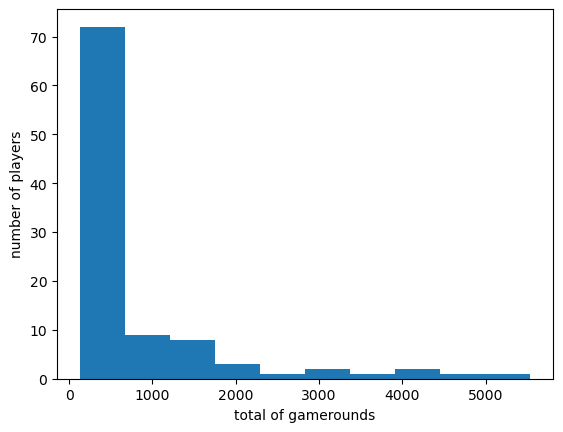

In [4]:
plot_df = df.groupby(by='sum_gamerounds')['userid'].count()

ax = plot_df.head(100).plot(kind='hist')
ax.set_xlabel('total of gamerounds')
ax.set_ylabel('number of players')

In [5]:
df[df['sum_gamerounds']==0]['userid'].count()

3994

[INSIGHT: 0-1000사이의 게임 라운드가 가장 많다. 그 이상의 숫자에서는 이용자 수가 많이 감소한다.
설치 후 한판도 하지 않은 이용자도 3994명이나 된다. ]


In [6]:
#1일 후 돌아온 이용자 비율
#df['retention_1'].sum()/df['retention_1'].count() 
df['retention_1'].mean()

0.4452095044850259

In [7]:
#7일 후 돌아온 이용자 비율
df['retention_7'].mean()

0.1860648194347426

[INSIGHT : 1일 후 돌아온 이용자는 44.5%이지만 7일 후 돌아온 이용자 비율은 전체중 18.6%이다. 훨씬 떨어진 수치이다]
* 게이트 별로 돌아온 사람들의 차이를 살펴보자

In [8]:
#1일 후 돌아온 사람들 명수 --> 게이트 별로 
#True인 사람들 :'1'을 더함
df.groupby(by='version')['retention_1'].sum()

version
gate_30    20034
gate_40    20119
Name: retention_1, dtype: int64

In [9]:
#1일 후 돌아온 사람들 비율 --> 게이트 별로 
df.groupby('version')['retention_1'].mean()

version
gate_30    0.448188
gate_40    0.442283
Name: retention_1, dtype: float64

# A/B testing : 부트스트래핑

통계적 추정으로 위해 resampled data 이용하기  
repeatedly re-sample dataset 

In [10]:
boot_1d = []
boot_7d = []

## retention rate distribution

In [11]:
for i in range(500):
    boot_mean_1 = df.sample(frac = 1, #fraction of rows to return, 1 means all the rows
                                 replace = True #after row is selected, it is put back 
                                 ).groupby('version')['retention_1'].mean()
    boot_mean_7 = df.sample(frac =1, 
                                    replace =True
                                       ).groupby('version')['retention_7'].mean()
    boot_1d.append(boot_mean_1)
    boot_7d.append(boot_mean_7)

Text(0.5, 1.0, '7 day retention rate distribution')

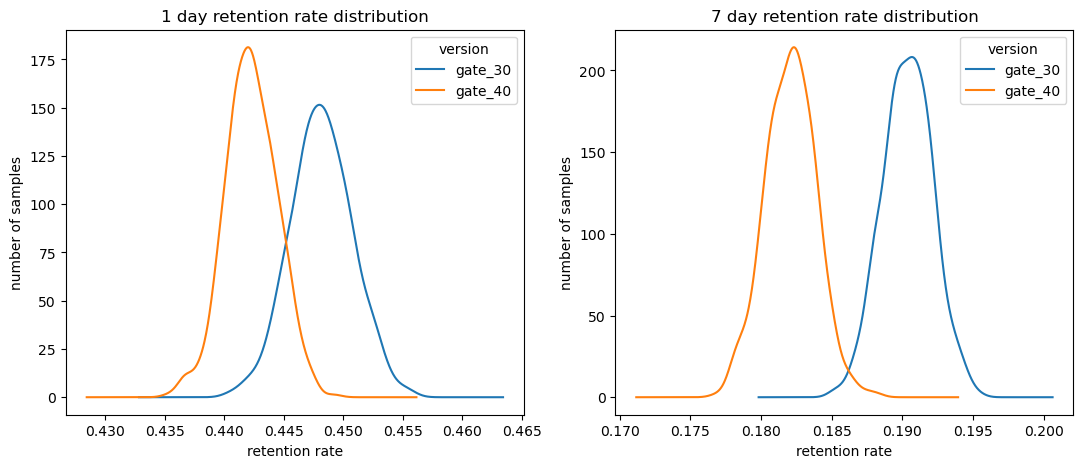

In [13]:
import matplotlib.pyplot as plt
#kernel density estimate 
#retention rate distribution 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(13,5))

pd.DataFrame(boot_1d).plot(kind='kde', ax = ax1)
ax1.set_xlabel('retention rate')
ax1.set_ylabel('number of samples')
ax1.set_title('1 day retention rate distribution')

pd.DataFrame(boot_7d).plot(kind ='kde', ax =ax2)
ax2.set_xlabel('retention rate')
ax2.set_ylabel('number of samples')
ax2.set_title('7 day retention rate distribution')

[INSIGHT: 작지만 gate가 30일 때와 40일때에 유의미한 차이가 있다]

## Difference between A/B groups

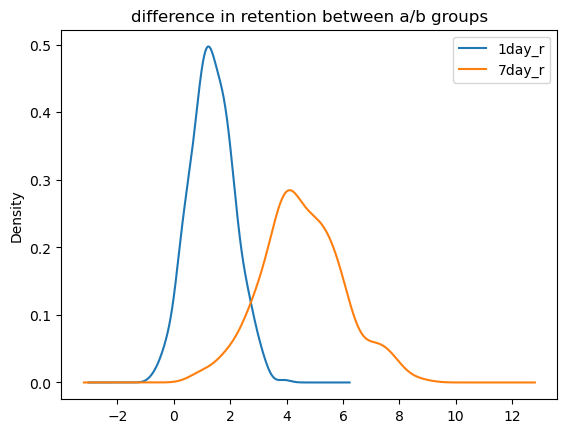

In [19]:
#A/B그룹간의 차이 (비율)
boot_1d = pd.DataFrame(boot_1d)
boot_7d = pd.DataFrame(boot_7d)

boot_1d['diff'] = (boot_1d['gate_30']-boot_1d['gate_40'])/boot_1d['gate_40'] *100
boot_7d['diff'] = (boot_7d['gate_30']-boot_7d['gate_40'])/boot_7d['gate_40'] * 100

fig, ax = plt.subplots(1,1)
boot_1d['diff'].plot(kind='kde', label ='1day_r')
boot_7d['diff'].plot(kind='kde', label ='7day_r')
ax.set_title('difference in retention between a/b groups')
plt.legend()

1일 리텐션 : 게이트 30과 40의 % 차이는 1-2%이다.   
7일 리텐션 : 게이트 30과 40의 % 차이는 2-5%이다.   
- 차이가 0%이상일 확률은?

In [26]:
prob_1 = (boot_1d['diff'] > 0).sum()/len(boot_1d['diff'])
prob_7 = (boot_7d['diff'] > 0).sum()/len(boot_7d['diff'])

In [27]:
print(prob_1, prob_7)

0.964 1.0


 A/B testing : 게이트 3 vs. 게이트 4  
- 1일 리텐션: 게이트 3일때 더 클 확률 : 96.4%  
- 7일 리텐션: 게이트 3일때 더 클 확률 : 100%